In [1]:
import sys
import time
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

data_dir = Path("measurements")
state_dir = Path("state_vectors")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

results_err_dir = Path("results_error")
results_err_dir.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")


Running on: cpu


In [2]:
def train_experiment_model(
        file_paths: List[Path],
        n_samples: int,
        config: Dict[str, Any],
        rng: torch.Generator,
        device: torch.device,
) -> SymmetricHyperRBM:

    dataset = MeasurementDataset(
        file_paths,
        load_measurements_npz,
        ["h"],
        [n_samples] * len(file_paths),
    )
    loader = MeasurementLoader(
        dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        drop_last=False,
        rng=rng,
    )

    model = SymmetricHyperRBM(
        num_v=dataset.num_qubits,
        num_h=config["num_hidden"],
        hyper_dim=config["hyper_dim"],
        k=config["k_steps"],
    ).to(device)
    model.initialize_weights(std=config["init_std"])

    optimizer = torch.optim.Adam(model.parameters(), lr=config["init_lr"])

    steps = config["epochs"] * len(loader)
    scheduler = get_sigmoid_curve(config["init_lr"], config["final_lr"], steps, 0.005)

    model = train_loop(
        model,
        optimizer,
        loader,
        num_epochs=config["epochs"],
        lr_schedule_fn=scheduler,
        noise_frac=config["gibbs_noise"],
        rng=rng,
    )

    return model


def evaluate_overlap_sweep(
        model: SymmetricHyperRBM,
        h_values: List[float],
        gt_wavefunctions: Dict[float, torch.Tensor],
        basis_states: torch.Tensor,
) -> List[float]:

    overlaps = []
    for h in h_values:
        psi_true = gt_wavefunctions[h]
        ov = calculate_exact_overlap(model, h, psi_true, basis_states)
        overlaps.append(ov)
    return overlaps


In [3]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000

SAMPLE_SIZES = [2_000, 5_000, 20_000]

H_TRAIN = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
H_EVAL  = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
ALL_H = sorted(list(set(H_TRAIN + H_EVAL)))

all_seeds = list(range(42, 52))

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in H_TRAIN]
file_paths = [data_dir / fn for fn in file_names]

print("Pre-loading ground truth wavefunctions...")
all_states = generate_basis_states(SIDE_LENGTH**2, device)
gt_map: Dict[float, torch.Tensor] = {}

for h_val in ALL_H:
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    gt_map[h_val] = load_gt_wavefunction(gt_path, device)

print(f"Loaded {len(gt_map)} GT states.")


Pre-loading ground truth wavefunctions...
Loaded 14 GT states.


In [4]:
from joblib import Parallel, delayed

TRAIN_CONFIG = {
    "epochs": 50,
    "batch_size": 1024,
    "num_hidden": 64,
    "hyper_dim": 64,
    "k_steps": 10,
    "init_lr": 1e-2,
    "final_lr": 1e-4,
    "gibbs_noise": 0.1,
    "init_std": 0.05,
}

def _is_support(h: float) -> bool:
    return any(np.isclose(h, s) for s in H_TRAIN)

def run_seed_experiment(SEED: int) -> pd.DataFrame:
    torch.manual_seed(SEED)
    rng = torch.Generator(device=str(device)).manual_seed(SEED)

    results_df = pd.DataFrame({"h": ALL_H})
    results_df["type"] = results_df["h"].apply(lambda x: "support" if _is_support(float(x)) else "novel")

    print(f"Starting Experiment Loop: {SAMPLE_SIZES} (Seed={SEED})")

    for n_samples in SAMPLE_SIZES:
        print(f"\n### RUNNING: {n_samples} samples per support point (Seed={SEED}) ###")

        model = train_experiment_model(file_paths, n_samples, TRAIN_CONFIG, rng, device)
        overlaps = evaluate_overlap_sweep(model, ALL_H, gt_map, all_states)

        col_name = f"overlap_{n_samples}"
        results_df[col_name] = overlaps

        print(f"Finished {col_name}. Mean Overlap: {np.nanmean(overlaps):.5f}")

    results_df["seed"] = SEED
    return results_df


print("Starting parallel experiments over seeds...")
all_results = Parallel(n_jobs=5)(delayed(run_seed_experiment)(SEED) for SEED in all_seeds)

print("\nAll experiments finished.")

final_results_df = pd.concat(all_results, ignore_index=True)
final_results_df.head()


Starting parallel experiments over seeds...

All experiments finished.


,h,type,overlap_2000,overlap_5000,overlap_20000,seed
0,1.0,support,0.998943,0.999498,0.999780,42
1,1.5,novel,0.997731,0.998802,0.999303,42
2,2.0,support,0.992365,0.997804,0.999042,42
3,2.5,novel,0.980379,0.994577,0.998055,42
4,2.8,novel,0.977379,0.992736,0.997369,42


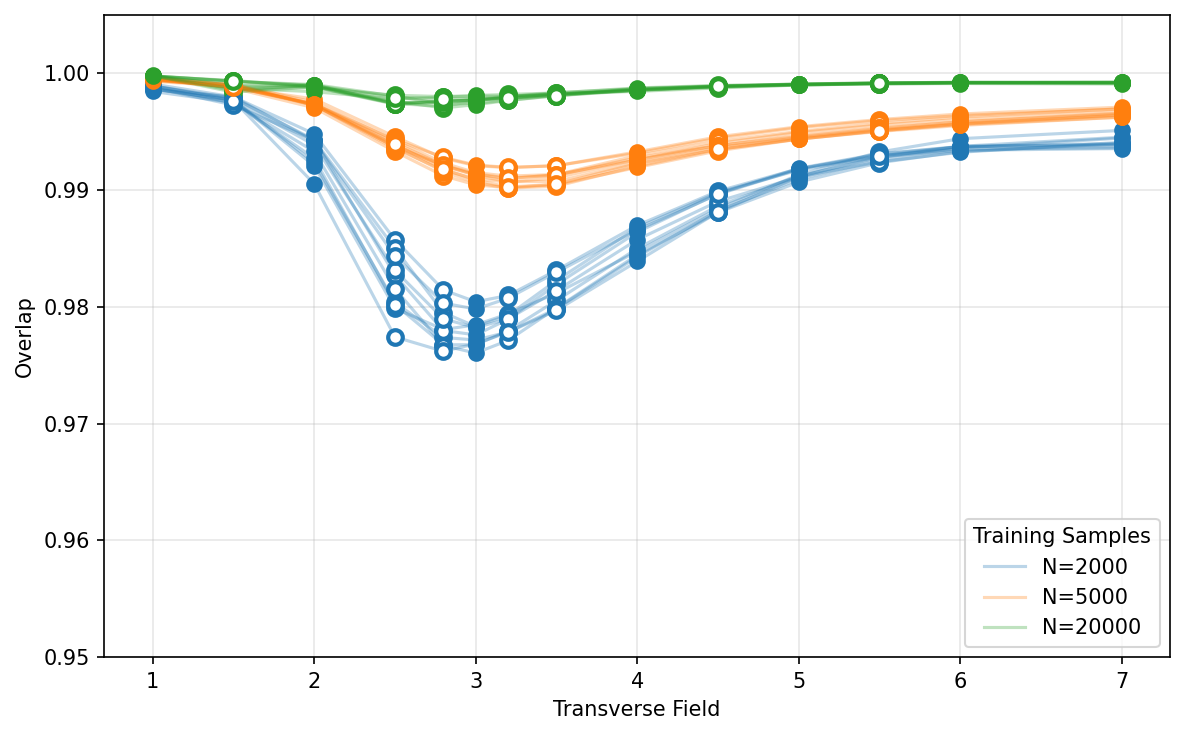

In [5]:
plt.figure(figsize=(8, 5), dpi=150)

seed0 = final_results_df["seed"].unique()[0]

for SEED in final_results_df["seed"].unique():
    seed_df = final_results_df[final_results_df["seed"] == SEED]
    support_df = seed_df[seed_df["type"] == "support"]
    novel_df = seed_df[seed_df["type"] == "novel"]

    for i, n_samples in enumerate(SAMPLE_SIZES):
        col = f"overlap_{n_samples}"

        plt.plot(
            seed_df["h"], seed_df[col],
            "-",
            color=f"C{i}",
            alpha=0.3,
            label=f"N={n_samples}" if SEED == seed0 else None,
        )
        plt.plot(support_df["h"], support_df[col], "o", color=f"C{i}", markersize=7)
        plt.plot(novel_df["h"], novel_df[col], "o", color=f"C{i}", mfc="white", mew=2, markersize=7)

plt.xlabel("Transverse Field")
plt.ylabel("Overlap")
plt.ylim(0.95, 1.005)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", title="Training Samples")
plt.tight_layout()
plt.show()

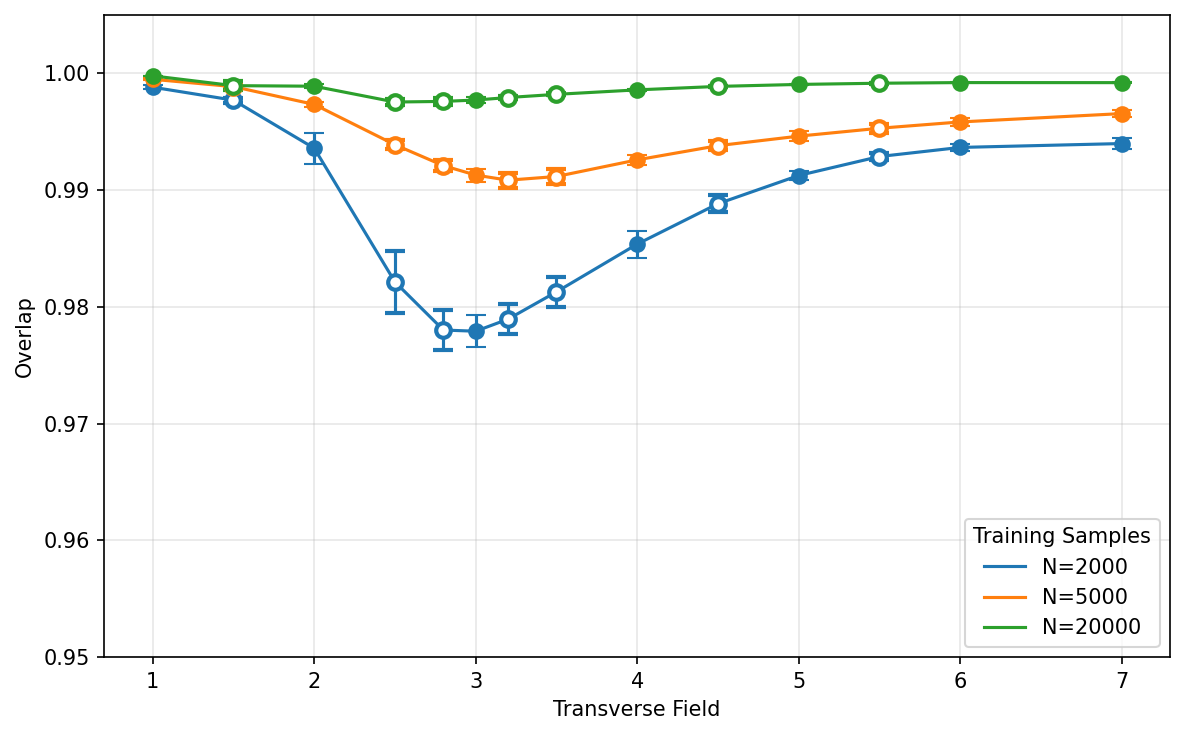

,h,type,overlap_2000,overlap_2000_err,overlap_5000,overlap_5000_err,overlap_20000,overlap_20000_err
0,1.0,support,0.998815,0.000188,0.999492,0.000082,0.999788,0.000025
1,1.5,novel,0.997702,0.000223,0.998864,0.000113,0.998948,0.000370
2,2.0,support,0.993591,0.001321,0.997340,0.000197,0.998900,0.000177
3,2.5,novel,0.982134,0.002623,0.993886,0.000382,0.997546,0.000293
4,2.8,novel,0.978014,0.001712,0.992097,0.000492,0.997599,0.000312


In [6]:
# Aggregate over seeds: mean + std (saved as *_err), and plot with error bars
agg_df = pd.DataFrame({"h": ALL_H})
agg_df["type"] = agg_df["h"].apply(lambda x: "support" if _is_support(float(x)) else "novel")

for n_samples in SAMPLE_SIZES:
    col = f"overlap_{n_samples}"
    stats = (
        final_results_df
        .groupby("h")[col]
        .agg(["median", "std"])
        .reset_index()
        .rename(columns={"median": col, "std": f"{col}_err"})
    )
    agg_df = agg_df.merge(stats, on="h", how="left")

plt.figure(figsize=(8, 5), dpi=150)

support_mask = agg_df["type"].values == "support"
novel_mask   = agg_df["type"].values == "novel"

for i, n_samples in enumerate(SAMPLE_SIZES):
    col = f"overlap_{n_samples}"
    err = f"{col}_err"

    # line through all points (means)
    plt.plot(agg_df["h"], agg_df[col], "-", color=f"C{i}", label=f"N={n_samples}")

    # support points (filled)
    plt.errorbar(
        agg_df.loc[support_mask, "h"],
        agg_df.loc[support_mask, col],
        yerr=agg_df.loc[support_mask, err],
        fmt="o",
        color=f"C{i}",
        markersize=7,
        capsize=5,
        linestyle="None",
    )

    # novel points (open)
    plt.errorbar(
        agg_df.loc[novel_mask, "h"],
        agg_df.loc[novel_mask, col],
        yerr=agg_df.loc[novel_mask, err],
        fmt="o",
        color=f"C{i}",
        mfc="white",
        mew=2,
        markersize=7,
        capsize=5,
        linestyle="None",
    )

plt.xlabel("Transverse Field")
plt.ylabel("Overlap")
plt.ylim(0.95, 1.005)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", title="Training Samples")
plt.tight_layout()
plt.show()

agg_df.head()


In [7]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_sample_eff_rbm_err_{timestamp}.csv"
save_path = results_err_dir / filename

agg_df.to_csv(save_path, index=False, float_format="%.6f")
print(f"Aggregated experiment results (mean + std) saved to: {save_path}")


Aggregated experiment results (mean + std) saved to: results_error/tfim_4x4_sample_eff_rbm_err_20260123_112349.csv
